# Speech Emotion Recognition using CNN with RAVDESS dataset

You can run this notebook on local machine using Jupyter Notebook, or on Google Colab if you want to save some disk space. For Google Colab, you will mount this notebook to your Google Drive, download/save the dataset in the Drive.

#### About RAVDESS dataset

This is the Ryerson Audio-Visual Database of Emotional Speech and Song dataset, and is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. The entire dataset is 24.8GB from 24 actors, but we’ve lowered the sample rate on all the files. In our model, we are taking the `emotion` (third identifier) in consideration only.

**File naming convention**

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

**Filename identifiers**

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Download the dateset [here](https://drive.google.com/file/d/1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7/view?usp=sharing). Read more about the dataset [here](https://zenodo.org/record/1188976).

In [1]:
data_directory = "data/ravdess"

## 1. Download the dataset

**Local**

Download the dataset from [here](https://drive.google.com/file/d/1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7/view) and unzip to `data_directory` , and proceed to **[2. Install and import library](#2.-Install-and-import-libraries)**

**Google Colab**

Change this, your project directory. If you are using Colab, it will look like gdrive/My Drive/speech-emotion-recognition .

In [ ]:
root_path = '/'

In [ ]:
import os
os.chdir(root_path)

In [ ]:
!pip install PyDrive

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
if not os.path.exists('data'): 
    os.makedirs('data')

downloaded = drive.CreateFile({'id':"1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7"})   # replace the id with id of file you want to access
downloaded.GetContentFile('speech-emotion-recognition-dataset.zip')

!mv speech-emotion-recognition-dataset.zip data

if not os.path.exists(data_directory): 
    os.makedirs(data_directory)

!unzip data/speech-emotion-recognition-dataset.zip -d datasets/ravdess

## 2. Install and import libraries

In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import np_utils
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics

C:\Users\huaiyukhaw\anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 3. Functions

Open the sound file with soundfile.SoundFile using with-as so it’s automatically closed once we’re done. Read from it and call it X. Also, get the sample rate. If chroma is True, get the Short-Time Fourier Transform of X.

Let result be an empty numpy array. Now, for each feature of the three, if it exists, make a call to the corresponding function from librosa.feature (eg- librosa.feature.mfcc for mfcc), and get the mean value. Call the function hstack() from numpy with result and the feature value, and store this in result. hstack() stacks arrays in sequence horizontally (in a columnar fashion). Then, return the result.

In [3]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

**Extract features from audio files into numpy array**

In [4]:
def extract_feature(data, sr, mfcc, chroma, mel):
    
    """
    extract features from audio files into numpy array
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency
    
    """
    
    if chroma:                          
        stft = np.abs(librosa.stft(data))  
    result = np.array([])
    if mfcc:                          
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:                          
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:                             
        mel = np.mean(librosa.feature.melspectrogram(data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))
        
    return result 

#### Data Augmentation Techniques
There are two types of data augmentation for audio that we will be using

- Noise addition - add random white noises to the audio
- Shifting - shift the spectogram in a direction

**Add white noise to the audio dataset**

In [5]:
def noise(data, noise_factor):
    
    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added 

    """
    noise = np.random.randn(len(data)) 
    augmented_data = data + noise_factor * noise
    
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

**Shift the spectogram in a direction**

In [6]:
def shift(data, sampling_rate, shift_max, shift_direction):
    
    """
    shift the spectogram in a direction
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both
    
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
        
    return augmented_data

**Loading dataset**

There is a total of 8 emotions that can be observed in the RAVDESS dataset.

Each file in the RAVDESS dataset has a unique filename. The filename consists of 7 numbers separated by dashes (e.g. 02-01-06-01-02-01-12.mp4). These numbers define the stimulus characteristics in the following order:
 
Filename identifiers 
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
- Vocal channel (01 = speech, 02 = song)
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door")
- Repetition (01 = 1st repetition, 02 = 2nd repetition)
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female)atures, and label data**

In [7]:
def load_data(save=False):
    
    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy

    """
    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.    
        data, sr = librosa.load(file)
        
        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)
        
        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]  
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)
    
    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)
        
    return np.array(x), y

## 3. Data processing

**Read in, extract features, and label data**

In [8]:
X, y = load_data(save=True)

# X = np.load("X.npy")
# y = np.load("y.npy")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

**Encode the data labels**

In [9]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [10]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


## 4. Model training

**Define the model and optimizer**

In [11]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))
opt = keras.optimizers.adam(decay=1e-6)

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

**Start training the model**

In [13]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Train on 3240 samples, validate on 1080 samples
Epoch 1/100
3240/3240 [==============================] - 13s 4ms/step - loss: 2.2908 - accuracy: 0.2182 - val_loss: 1.9666 - val_accuracy: 0.2963
Epoch 2/100
3240/3240 [==============================] - 12s 4ms/step - loss: 1.9333 - accuracy: 0.3198 - val_loss: 1.8253 - val_accuracy: 0.3880
Epoch 3/100
3240/3240 [==============================] - 12s 4ms/step - loss: 1.8155 - accuracy: 0.3793 - val_loss: 1.7237 - val_accuracy: 0.3981
Epoch 4/100
3240/3240 [==============================] - 12s 4ms/step - loss: 1.7252 - accuracy: 0.4056 - val_loss: 1.6974 - val_accuracy: 0.4102
Epoch 5/100
3240/3240 [==============================] - 12s 4ms/step - loss: 1.6437 - accuracy: 0.4364 - val_loss: 1.5928 - val_accuracy: 0.4685
Epoch 6/100
3240/3240 [==============================] - 12s 4ms/step - loss: 1.5536 - accuracy: 0.4849 - val_loss: 1.4920 - val_accuracy: 0.5102
Epoch 7/100
3240/3240 [==============================] - 12s 4ms/step - loss

## 5. Model evaluation

- plot learning curve
- draw confusion matrix
- calculate F1 score

**Plot the learning curve of the model with its accuracy**

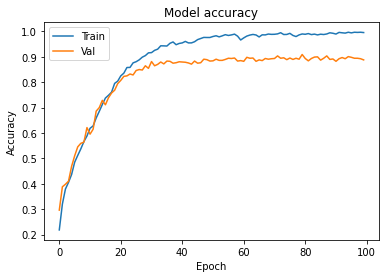

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

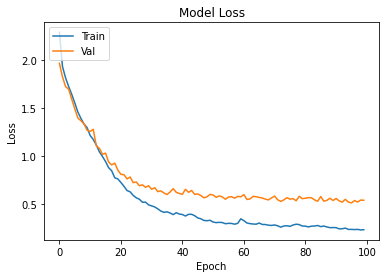

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

**Use the test data to do prediction**

In [16]:
y_pred = model.predict(XTestProcessed)

**Draw a confusion matrix**

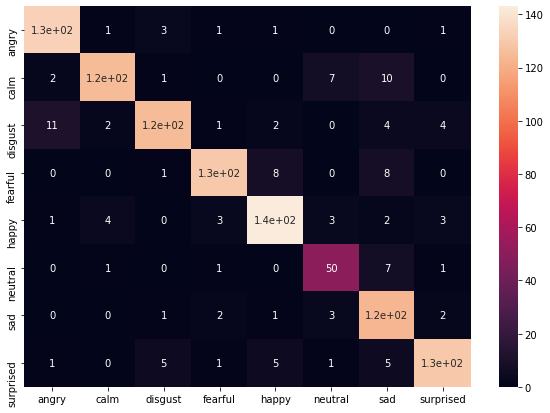

In [17]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

**Calculate the F1 score of the model**

F1 score is a measure of a test's accuracy. F1 score combines precision and recall relative to a specific positive class - The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0

In [18]:
f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')

0.8886246256820012

**Model summary**

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 180, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 180, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 180, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 180, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 128)          

## 6. Save and load the trained model.

In [20]:
# Save the trained model to disk
if not os.path.exists('models'): 
    os.makedirs('models')

model.save("models/cnn.h5")

In [21]:
# Load the model from disk
loaded_model = keras.models.load_model("models/cnn.h5")

## 7. Playground

In [22]:
# Load the data and extract features for each sound file
def load_single_data(file):
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

In [ ]:
XX, yy = load_single_data("data/ravdess/Actor_01/03-01-05-02-02-02-01.wav")

In [24]:
yy

['angry']

In [25]:
# Predict for the test set
XXTemp=np.expand_dims(XX, axis=2)
XX, yy = load_single_data("data/ravdess/Actor_01/03-01-05-02-02-02-01.wav") = model.predict(XXTemp)


In [26]:
list(y_pred)

[array([9.9690741e-01, 3.8878224e-04, 7.4552448e-04, 1.0804559e-04,
        6.8968389e-04, 2.3291443e-04, 6.7373371e-04, 2.5409379e-04],
       dtype=float32)]